# Classifying the Risk Intensity Level for Maternal Mortality during Pregnancy
#### Raychal Ng, Aniket Chakraborty, Hamrah R, Revanda Ghassan R

## Introduction

This dataset presents six factors that affect maternal mortality: age; systolic BP ( pressure in the arteries when the heart beats in mmHg); diastolic BP (pressure in the arteries during rests between beats in mmHg); blood sugar (blood glucose level in mmol/L), body temperature (in Fahrenheit), and heart rate in beats per minute. Deviation from normal levels in these factors contributes to maternal mortality. The data was obtained from different hospitals and clinics in Bangladesh. It was collected using the loT-based risk monitoring system which contains data from mechanical and digital machines used on patients. The risk level for mortality was classified for 1014 pregnancies based on midwifery assessments. 

#### Predictive Question
We aim to answer the question: Can we reliably predict maternal mortality in the future based on data collected during patient admission, i.e. age, systolic BP, diastolic BP and blood sugar.

## Methods & Results

### Preliminary Exploratory Data Analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(RColorBrewer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes:

In [2]:
maternal_health_dataset <- read_csv("https://raw.githubusercontent.com/aniketc12/maternal_risk/main/data/maternal_health_risk.csv") 
maternal_health_dataset <- maternal_health_dataset |>
    mutate(RiskLevel =as_factor(RiskLevel)) #the RiskLevel was mutated to be a factor instead of a character input
colnames(maternal_health_dataset) <- c("Age", "SystolicBP", "DiastolicBP", "BloodSugar", "BodyTemp", "HeartRate", "RiskLevel") #all column names remained the same, except "BS" was changed to "BloodSugar" for easier readability

Rows: 1014 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): RiskLevel
dbl (6): Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
set.seed(1) #seed was set to ensure reproducibility of code 
maternal_health_dataset <- maternal_health_dataset |>
    select(!c("BodyTemp", "HeartRate")) #select for all columns except BodyTemp and HeartRate as these were not a part of our chosen variables (discussed in graphs 1-4) 
maternal_split <- initial_split(maternal_health_dataset, prop = 0.75, strata = RiskLevel) #the dataset was split into a training and testing set
training_set <- training(maternal_split) #the training set will be used for building the classifier
testing_set <- testing(maternal_split) #the testing set will be saved until the end to test the accuracy of the classifier

#### Graphs 

#### Table 1: Number of Observations in Each Maternal Mortality Risk Level 

In Table 1, the distribution of the three risk levels for maternal mortality in the training data was tabulated to determine the spread of data across the classes.

In [4]:
risk_distribution <- training_set |>
group_by(RiskLevel) |> #the data was grouped by the three risk levels
summarize(n=n()) # the number of observations in each class was summarized
risk_distribution

RiskLevel,n
<fct>,<int>
high risk,204
low risk,304
mid risk,252


The training data was grouped by the three risk levels for maternal mortality and then the number of observations in each group was summarized. As the number of observations in each class is relatively equal (204-304), no further balancing of data is needed and we can proceed with building the classifier.  

#### Table 2: Tabulation of the total number of ‘NA’ values in the training data 

In [5]:
na <- tibble(number_of_na_values = sum(is.na(training_set))) 
na

number_of_na_values
<int>
0


In table 2, the total number of NA values across the training set was summed to determine if there was any missing data in the observations.  However, none of the observations contain an NA value so no special wrangling of data is required and all observations can be used to build the classifier. 

### Tables 3 to 5

Tables 3 to 5 shows the range (max and min) of the four chosen variables (age, systolic BP, diastolic BP, and blood sugar) for high, mid and low risk pregnancies, respectively. There is a wide range of data for each class and the max and min of the four variables do not differ drastically between the classes, thus examination of the distribution of each variable across the classes must be conducted.

#### Table 3: Max and Minimum Values of the Four Chosen Variables in High Risk Pregnancies

In [6]:
min_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |> #the dataset was filtered to only show observations from the high risk class
    select(!RiskLevel) |> #all columns except the 'RiskLevel' variable was selected for as we already know all observations are from the high risk level
    map_df(min) #the minimum value of each variable was determined

max_vals_high <- training_set |>
    filter(RiskLevel == "high risk") |>
    select(!RiskLevel) |>
    map_df(max) #the maximum value of each variable was determined

high_risk_variable_range <- full_join(min_vals_high, max_vals_high) #the maximum and minimum values determined from above were joined into a table

high_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
12,83,60,6.1
65,160,100,19.0


Table 3 shows the range of each variable for pregnancies categorized as high risk: the age ranged from 12-65 years old, the Systolic BP ranged from 83-160 mmHg, the Diastolic BP ranged from 60-100 mmHg, and the blood sugar ranged from 6.1-19.0 mmol/L.

#### Table 4: Max and Minimum Values of the Four Chosen Variables in Mid Risk Pregnancies

In [7]:
min_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |>
    select(!RiskLevel) |>
    map_df(min)

max_vals_mid <- training_set |>
    filter(RiskLevel == "mid risk") |>
    select(!RiskLevel) |>
    map_df(max)

mid_risk_variable_range <- full_join(min_vals_mid, max_vals_mid)

mid_risk_variable_range


Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,50,6
60,140,100,18


Table 4 shows the range of each variable for pregnancies categorized as mid risk: the age ranged from 10-60 years old, the Systolic BP ranged from 70-140 mmHg, the Diastolic BP ranged from 50-100 mmHg, and the blood sugar ranged from 6-18 mmol/L.

#### Table 5: Max and Minimum Values of the Four Chosen Variables in High Risk Pregnancies

In [8]:
min_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |>
    select(!RiskLevel) |>
    map_df(min) 

max_vals_low <- training_set |>
    filter(RiskLevel == "low risk") |>
    select(!RiskLevel) |>
    map_df(max)

low_risk_variable_range <- full_join(min_vals_low, max_vals_low)

low_risk_variable_range

Joining, by = c("Age", "SystolicBP", "DiastolicBP", "BloodSugar")


Age,SystolicBP,DiastolicBP,BloodSugar
<dbl>,<dbl>,<dbl>,<dbl>
10,70,49,6
70,129,100,11


Table 5 shows the range of each variable for pregnancies categorized as low risk: the age ranged from 10-70 years old, the Systolic BP ranged from 70-129 mmHg, the Diastolic BP ranged from 49-100 mmHg, and the blood sugar ranged from 6-11 mmol/L.

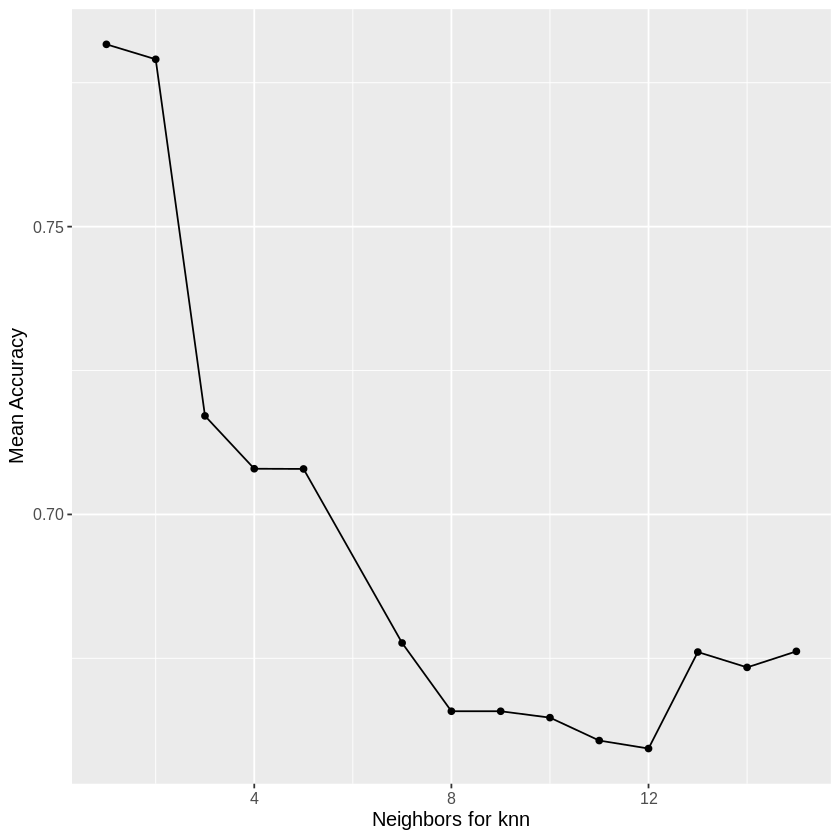

In [10]:
set.seed(1)

maternal_recipe <- recipe(RiskLevel ~ ., data=training_set) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

maternal_vfold <- vfold_cv(training_set, v = 10, strata = RiskLevel)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(maternal_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = maternal_vfold, grid = 20) |>
    collect_metrics() 

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors for knn", y = "Mean Accuracy") + 
  theme(text = element_text(size = 12))

accuracies_plot

In [11]:
best_k <- 2
best_knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

best_knn_fit <- workflow() |>
    add_recipe(maternal_recipe) |>
    add_model(best_knn_spec) |>
    fit(data=training_set)

testing_set_predictions <- predict(best_knn_fit, testing_set) |>
    bind_cols(testing_set)

testing_set_accuracies <- testing_set_predictions |>
    metrics(truth = RiskLevel, estimate = .pred_class) |>
    filter(.metric == "accuracy")

testing_set_accuracies

testing_set_confusion <- testing_set_predictions |>
    conf_mat(truth = RiskLevel, estimate = .pred_class)

testing_set_confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7913386


           Truth
Prediction  high risk low risk mid risk
  high risk        56        1        7
  low risk          4       86       18
  mid risk          8       15       59